In [1]:
# %pip install -U qiskit
from qiskit import __version__
print('Qiskit Sürümü: ', __version__)

Qiskit Sürümü:  1.0.2


## <b>Qiskit ile Grover Arama Algoritması </b>

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile, assemble
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import quantum_info
from qiskit.visualization import plot_bloch_multivector

## Grover için bir Oracle devresi oluşturulmalıdır
Kübit sayısı aranması istenilen sayısı 2 tabanında ifade edebilecek uzunlukta olmalıdır.
<br> Aşağıda bazı sayılar için Oracle örnekleri bulunmaktadır. Bu örnekte <b>"5"</b> sayısını aranması incelencektir.

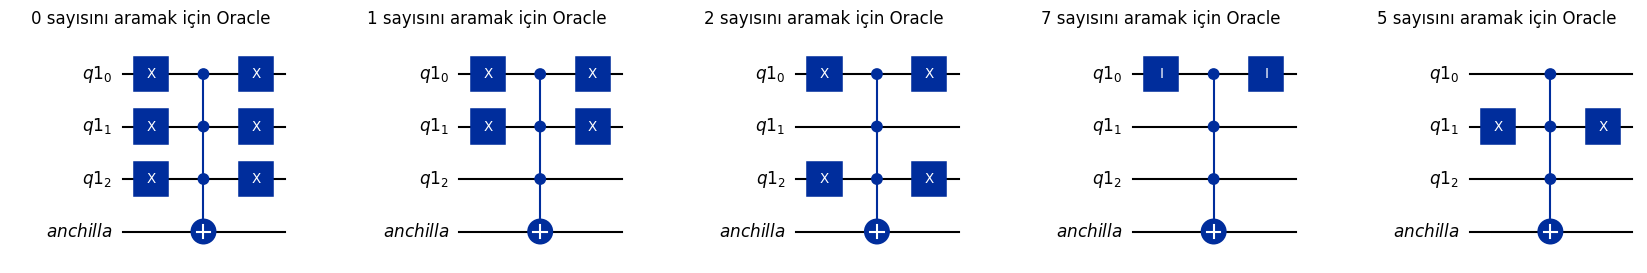

In [3]:
qubit_count = 3
qubits = QuantumRegister(qubit_count)
anchilla = QuantumRegister(1, name='anchilla')
oracle = QuantumCircuit(qubits, anchilla, name='Oracle')

# 0 sayısını aramak için Oracle devresi
oracle.x(0)
oracle.x(1)
oracle.x(2)
oracle.mcx(list(range(qubit_count)), anchilla)
oracle.x(0)
oracle.x(1)
oracle.x(2)

figure, axs = plt.subplots(1, 5, figsize=(21, 7))
axs[0].set_title('0 sayısını aramak için Oracle')
oracle.draw(output='mpl', ax=axs[0])

# 1 sayısını aramak için Oracle devresi
oracle = QuantumCircuit(qubits, anchilla, name='Oracle')
oracle.x(0)
oracle.x(1)
oracle.mcx(list(range(qubit_count)), anchilla)
oracle.x(0)
oracle.x(1)
axs[1].set_title('1 sayısını aramak için Oracle')
oracle.draw(output='mpl', ax=axs[1])

# 2 sayısını aramak için Oracle devresi
oracle = QuantumCircuit(qubits, anchilla, name='Oracle')
oracle.x(0)
oracle.x(2)
oracle.mcx(list(range(qubit_count)), anchilla)
oracle.x(0)
oracle.x(2)
axs[2].set_title('2 sayısını aramak için Oracle')
oracle.draw(output='mpl', ax=axs[2])

# 7 sayısını aramak için Oracle devresi
oracle = QuantumCircuit(qubits, anchilla, name='Oracle')
oracle.id(0)
oracle.mcx(list(range(qubit_count)), anchilla)
oracle.id(0)
axs[3].set_title('7 sayısını aramak için Oracle')
oracle.draw(output='mpl', ax=axs[3])

# 5 sayısını aramak için Oracle devresi
oracle = QuantumCircuit(qubits, anchilla, name='Oracle')
oracle.x(1)
oracle.mcx(list(range(qubit_count)), anchilla)
oracle.x(1)
axs[4].set_title('5 sayısını aramak için Oracle')
oracle.draw(output='mpl', ax=axs[4])

## Grover için bir Diffuser devresi oluşturulmalıdır
Çok kontrollü X kapısı kuantum devreye <b>QuantumCircuit().mcx(kontrol: list[qubits], hedef: qubit)</b> kullanarak eklenebilir

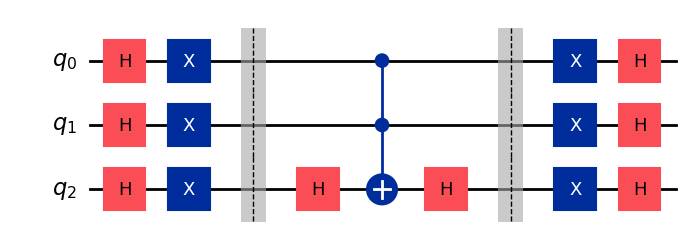

In [4]:
diffuser_circuit = QuantumCircuit(qubit_count, name='Diffuser')

# Tam süperposizyon oluştur (H kapısı)
for qubit in range(qubit_count):
    diffuser_circuit.h(qubit)

# |00..0> -> |11..1> dönüşümü yap (X kapısı)
for qubit in range(qubit_count):
    diffuser_circuit.x(qubit)

diffuser_circuit.barrier()
# Multi kontrollü-X kapısı ekle (MCX)
diffuser_circuit.h(qubit_count-1)
diffuser_circuit.mcx(list(range(qubit_count-1)), qubit_count-1)
diffuser_circuit.h(qubit_count-1)

diffuser_circuit.barrier()
# |11..1> -> |00..0> dönüşümü (X kapısı)
for qubit in range(qubit_count):
    diffuser_circuit.x(qubit)

# Süperpozisyondan geri dön (H-kapısı)
for qubit in range(qubit_count):
    diffuser_circuit.h(qubit)

diffuser_circuit.draw(output='mpl')

## Grover devresi Oracle ve Diffuser kullanılarak oluşturulur
<b style='color:red;'> 1 Adım grover devresi

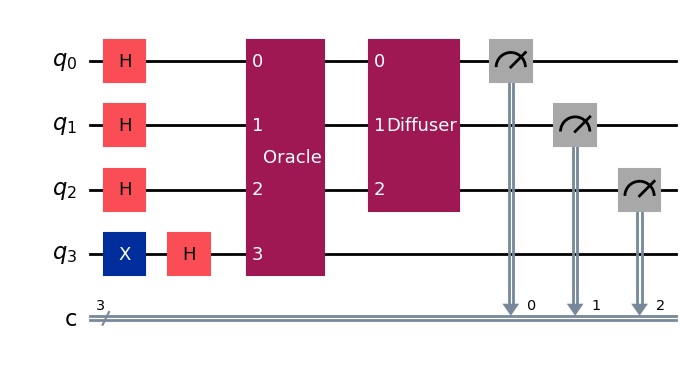

In [5]:
grover_circuit = QuantumCircuit(qubit_count+1, qubit_count)

for i in range(qubit_count):
    grover_circuit.h(i)
    
grover_circuit.x(qubit_count)
grover_circuit.h(qubit_count)

# Adım sayısı en az sqrt(N) kadar seçilmeli
step_count=1
for i in range(step_count):
    grover_circuit.append(oracle, range(qubit_count+1))
    grover_circuit.append(diffuser_circuit, range(qubit_count))

grover_circuit.measure(range(qubit_count), range(qubit_count))
grover_circuit.draw(output='mpl')

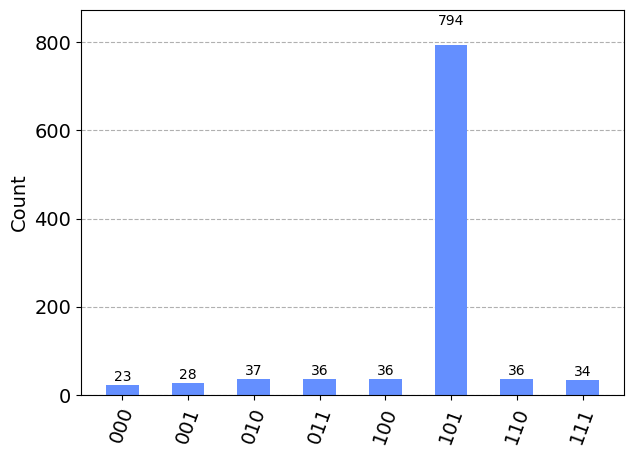

In [6]:
simulator = AerSimulator()
grover_circuit = transpile(grover_circuit, simulator)
result = simulator.run(grover_circuit).result().get_counts(0)
plot_histogram(result)

## Grover devresi Oracle ve Diffuser kullanılarak oluşturulur
<b style='color:red;'> 2 Adım grover devresi (bu örnekte daha ideal)

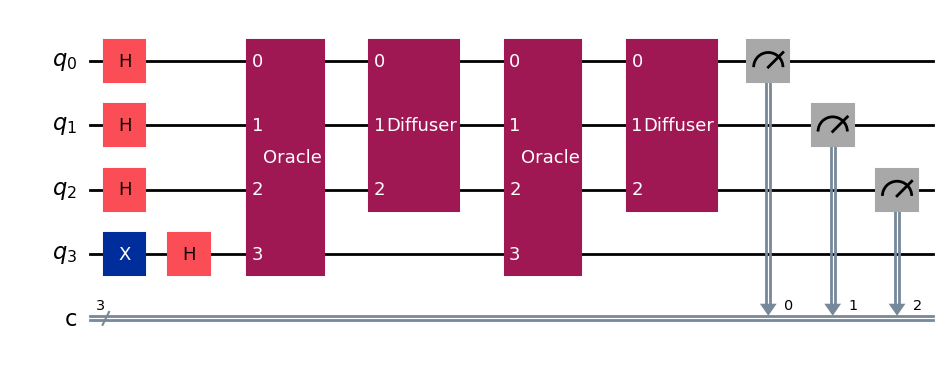

In [7]:
grover_circuit = QuantumCircuit(qubit_count+1, qubit_count)

for i in range(qubit_count):
    grover_circuit.h(i)
    
grover_circuit.x(qubit_count)
grover_circuit.h(qubit_count)

# Adım sayısı en az sqrt(N) kadar seçilmeli
step_count=2
for i in range(step_count):
    grover_circuit.append(oracle, range(qubit_count+1))
    grover_circuit.append(diffuser_circuit, range(qubit_count))

grover_circuit.measure(range(qubit_count), range(qubit_count))
grover_circuit.draw(output='mpl')

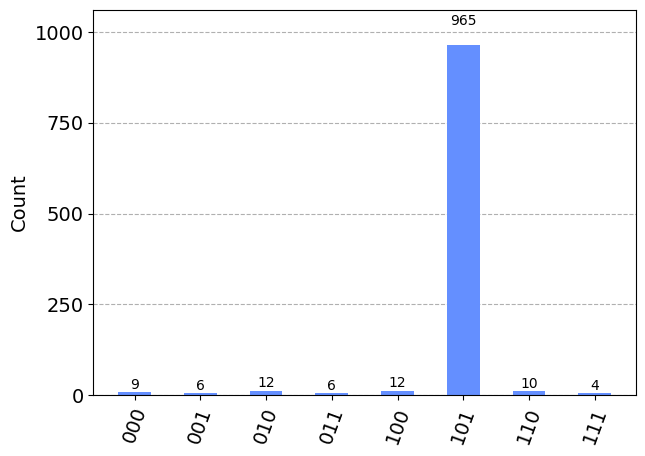

In [8]:
simulator = AerSimulator()
grover_circuit = transpile(grover_circuit, simulator)
result = simulator.run(grover_circuit).result().get_counts(0)
plot_histogram(result)

## Grover devresi Oracle ve Diffuser kullanılarak oluşturulur
<b style='color:red;'> 3 Adım grover devresi (ideal değil!)

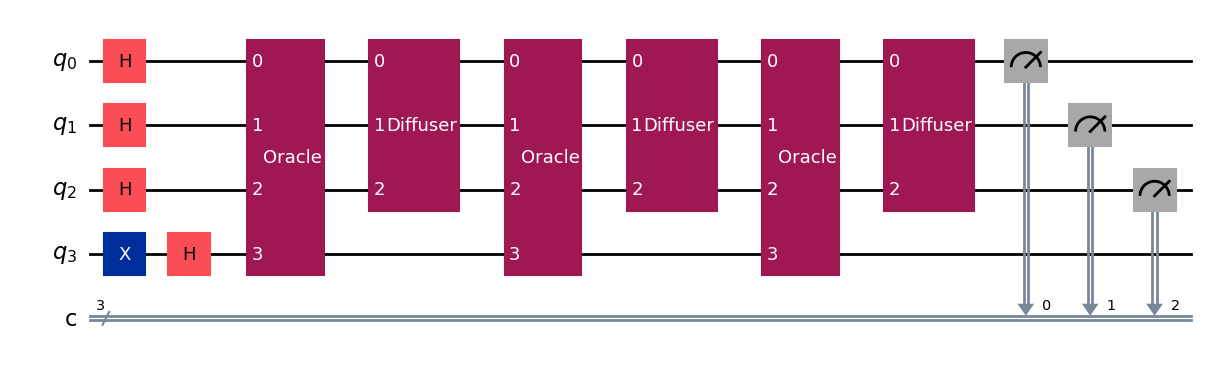

In [11]:
grover_circuit = QuantumCircuit(qubit_count+1, qubit_count)

for i in range(qubit_count):
    grover_circuit.h(i)
    
grover_circuit.x(qubit_count)
grover_circuit.h(qubit_count)

# Adım sayısı en az sqrt(N) kadar seçilmeli
step_count=3
for i in range(step_count):
    grover_circuit.append(oracle, range(qubit_count+1))
    grover_circuit.append(diffuser_circuit, range(qubit_count))

grover_circuit.measure(range(qubit_count), range(qubit_count))
grover_circuit.draw(output='mpl')

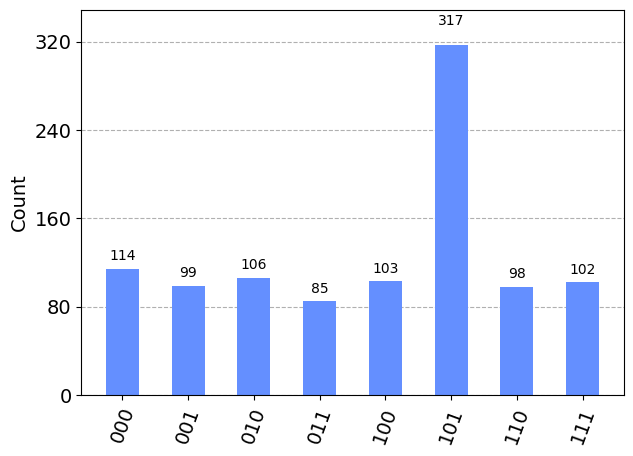

In [12]:
simulator = AerSimulator()
grover_circuit = transpile(grover_circuit, simulator)
result = simulator.run(grover_circuit).result().get_counts(0)
plot_histogram(result)